In [1]:
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

%matplotlib notebook

import sys, time
import numpy as np
import math as m
import matplotlib.pyplot as plt
import extra_data as ex
import xarray as xr
import dask.array as da
from extra_data.components import AGIPD1M
from matplotlib.colors import LogNorm
import matplotlib as mpl
from extra_geom import AGIPD_1MGeometry

from extra_geom import LPD_1MGeometry
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator


In [2]:
run = ex.open_run(proposal=3118, run=1)
#run.info()  # Show overview info about this data

In [3]:
from dask.distributed import Client, progress
from dask_jobqueue import SLURMCluster
partition = 'exfel'  # For EuXFEL staff
#partition = 'upex'   # For users

cluster = SLURMCluster(
    queue=partition,
    # Resources per SLURM job (per node, the way SLURM is configured on Maxwell)
    # processes=16 runs 16 Dask workers in a job, so each worker has 1 core & 16 GB RAM. silence_logs="debug",
    processes=5, cores=70, memory='600GB',nanny=True,death_timeout=100,walltime="24:00:00", job_name='run',
    local_directory = '/gpfs/exfel/exp/MID/201901/p002542/usr/Jo',log_directory = '/gpfs/exfel/exp/MID/201901/p002542/usr/Jo',
)

# Submit 2 SLURM jobs, for 32 Dask workers
cluster.scale(60)

client = Client(cluster)

# Get a notbook widget showing the cluster state
#cluster


# Loading AGIPD Data

In [4]:
# data address

cycle = 202202
proposal = 3118
run_no = 23



rundir_p = '/gpfs/exfel/exp/MID/{:06d}/p{:06d}/proc/r{:04d}'.format(cycle,proposal,run_no)
rundir_r = '/gpfs/exfel/exp/MID/{:06d}/p{:06d}/raw/r{:04d}'.format(cycle,proposal,run_no)

run_r = ex.RunDirectory(rundir_r)
run_p = ex.RunDirectory(rundir_p)

agp = AGIPD1M(run_p, min_modules=16)
arr = agp.get_dask_array("image.data")

arr = arr.unstack()

#arr

## AGIPD quadrant positions

In [5]:
#load positions of AGIPD quadrants
def load_AGIPD_Motors(run):
    motVal=[]
    for name in ( ['q1m1','q2m1','q3m1','q4m1','q1m2','q2m2','q3m2','q4m2']):
        prop = f'{name}ActualPosition'
        arr = run['MID_AGIPD_MOTION/MDL/DOWNSAMPLER',prop].xarray().data[0]
        motVal.append(arr)
    return motVal


q1m1, q2m1, q3m1, q4m1, q1m2, q2m2, q3m2, q4m2 = load_AGIPD_Motors(run_r)

q1_x = -542 + 0*q1m1
q1_y = 660 + q1m1/(-0.2)
q2_x = -608 + 0*q2m1
q2_y = -35 + q2m1/0.2
q3_x = 534 + 0*q3m1
q3_y = -221 + q3m1/0.2
q4_x = 588 + 0*q4m1
q4_y = 474 + q4m1/(-0.2)    
quad_pos = [(q1_x, q1_y),
               (q2_x, q2_y),
               (q3_x, q3_y),
               (q4_x, q4_y)]  

geom = AGIPD_1MGeometry.from_quad_positions(quad_pos=quad_pos)
# geom.inspect();

In [6]:
quad_pos

[(-542.0, 659.9349606968462),
 (-608.0, -34.99175307806581),
 (534.0, -220.99063917901367),
 (588.0, 473.9909150786698)]

<IPython.core.display.Javascript object>


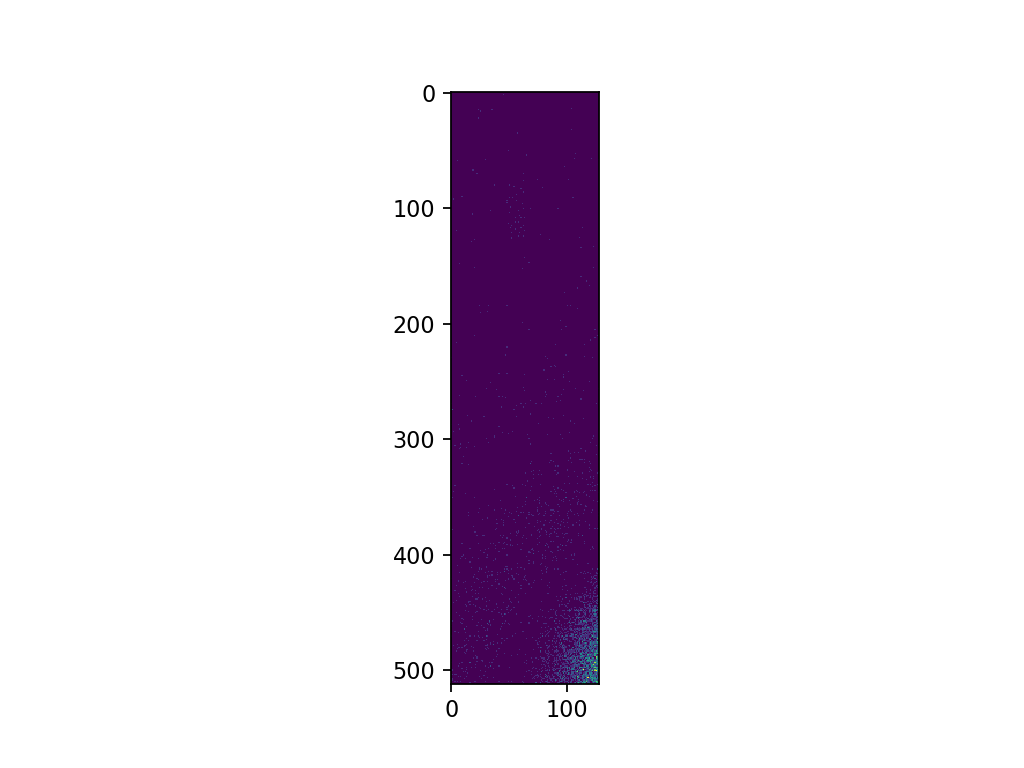

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x2b9a23e60c50>)

In [7]:
test_ = arr.isel(module = 3, pulseId = 51, trainId = 1000)
plt.figure(), plt.imshow(test_)

In [8]:
single_img = arr.isel(pulseId = 51, trainId = 1000)

<IPython.core.display.Javascript object>


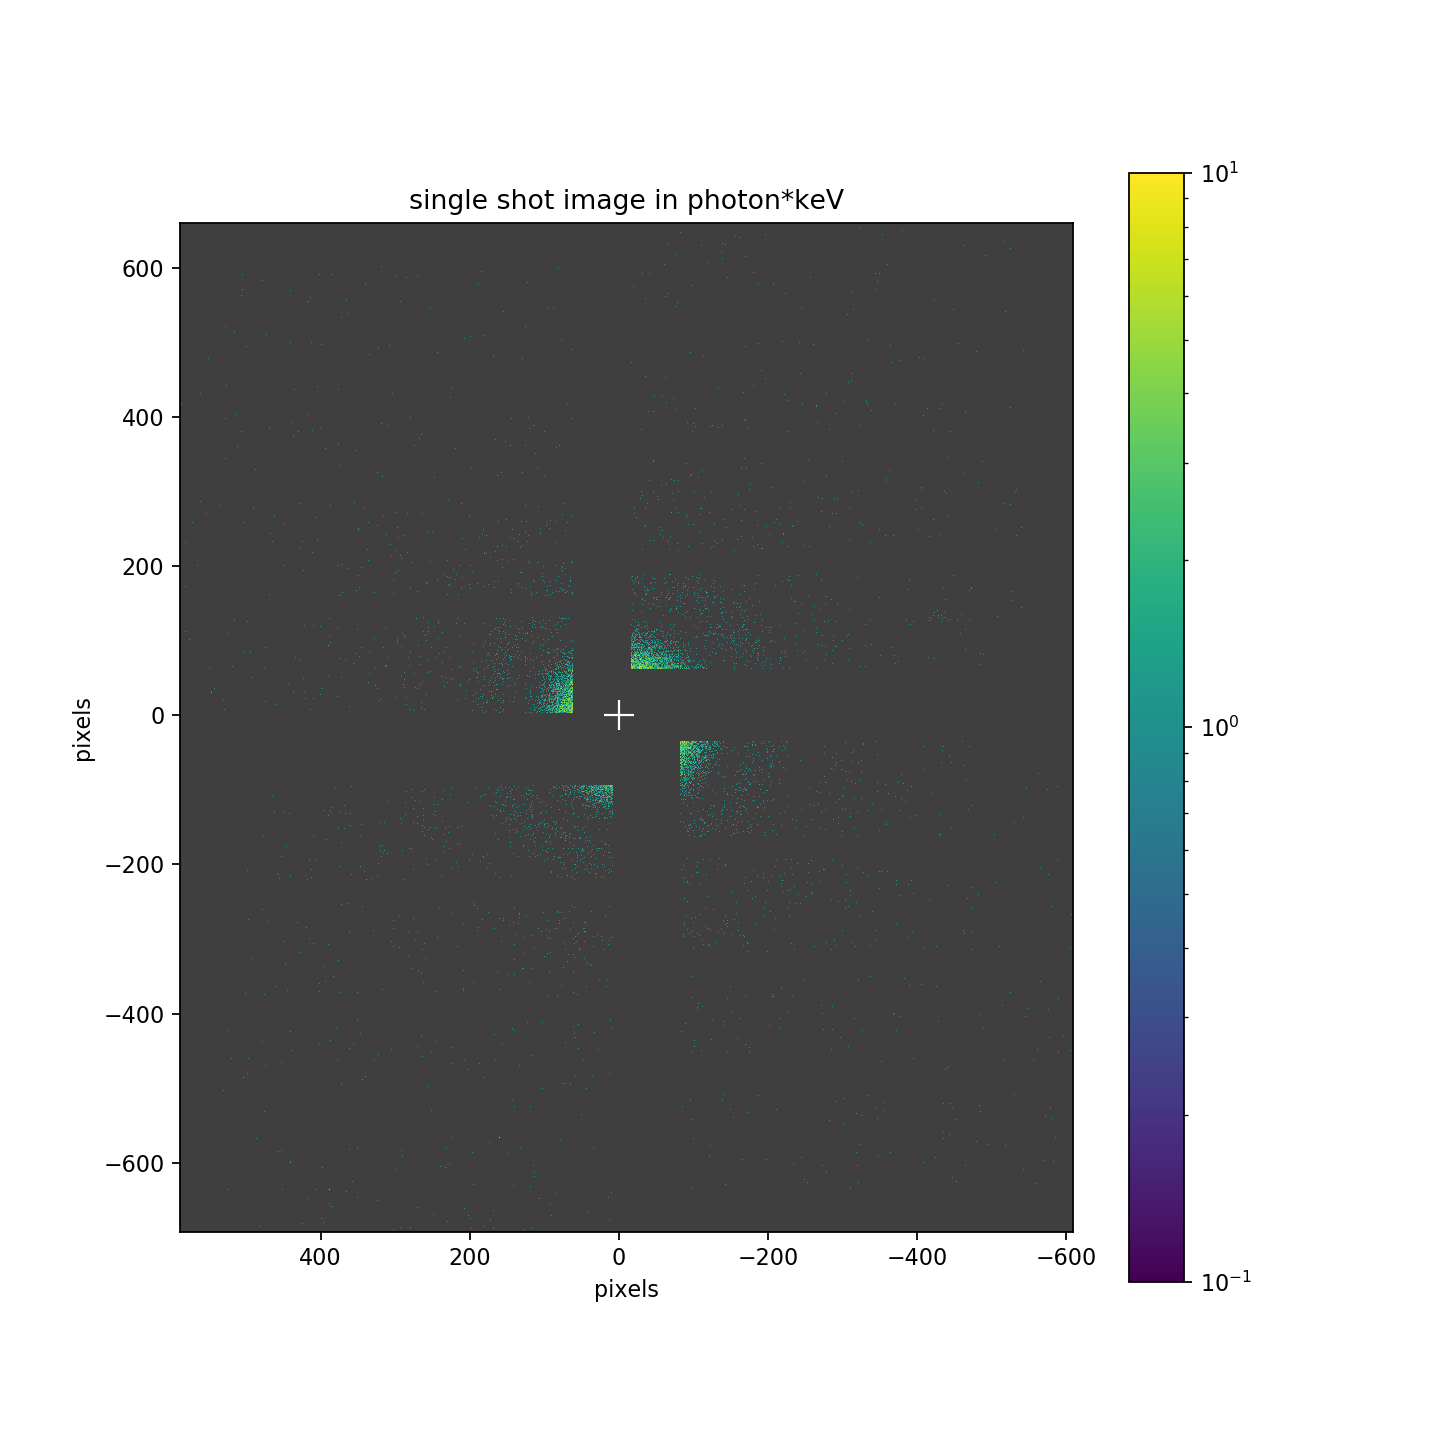

In [9]:
geom.plot_data_fast(single_img, figsize=(9, 9),norm = LogNorm(vmin = 1e-1, vmax = 1e1))
plt.title('single shot image in photon*keV')
plt.savefig('Averaged_image.png') 

In [6]:
mean_image = arr.isel(pulseId = slice(0,500),trainId = slice(1000)).mean(['pulseId','trainId']).compute()

<IPython.core.display.Javascript object>


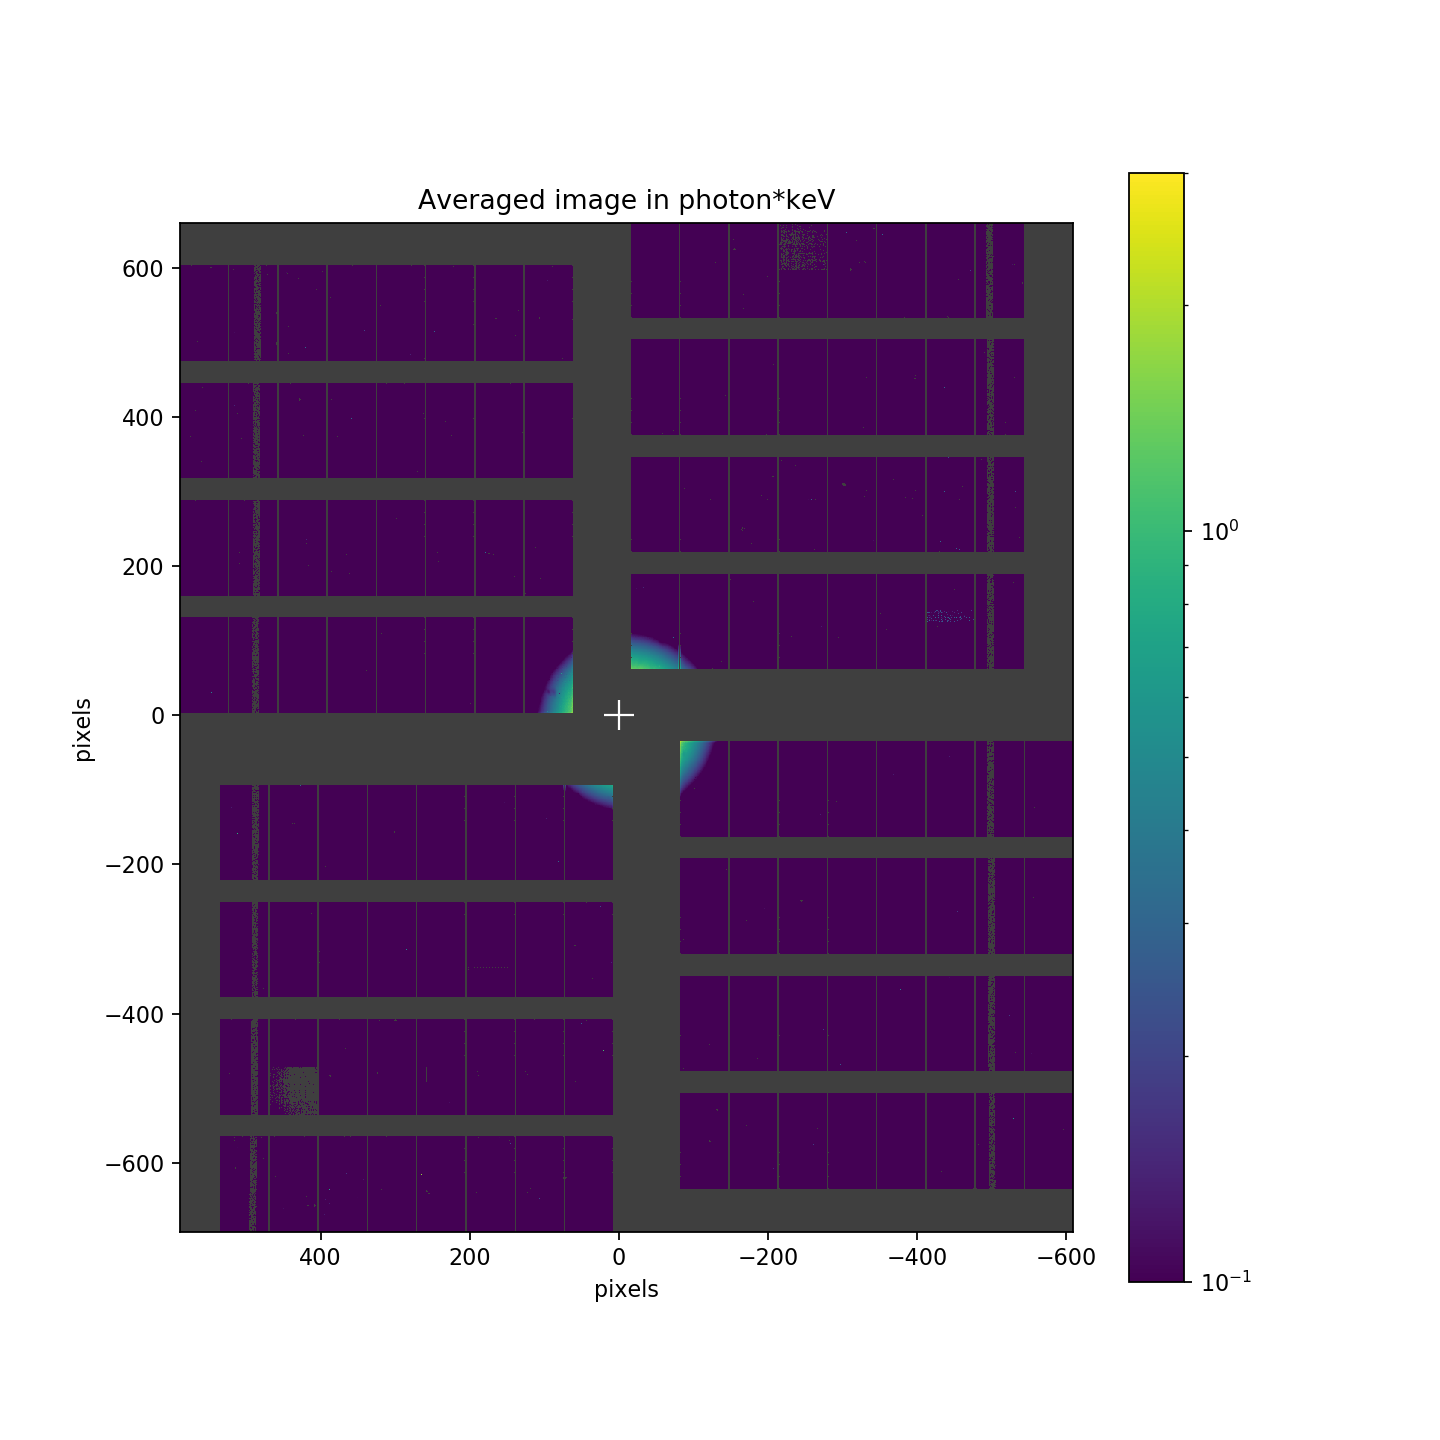

In [11]:
geom.plot_data_fast(mean_image, figsize=(9, 9),norm = LogNorm(vmin = 1e-1, vmax = 3e0))
plt.title('Averaged image in photon*keV')
plt.savefig('Averaged_image.jpeg') 

positions.shape = (16, 3)


<IPython.core.display.Javascript object>


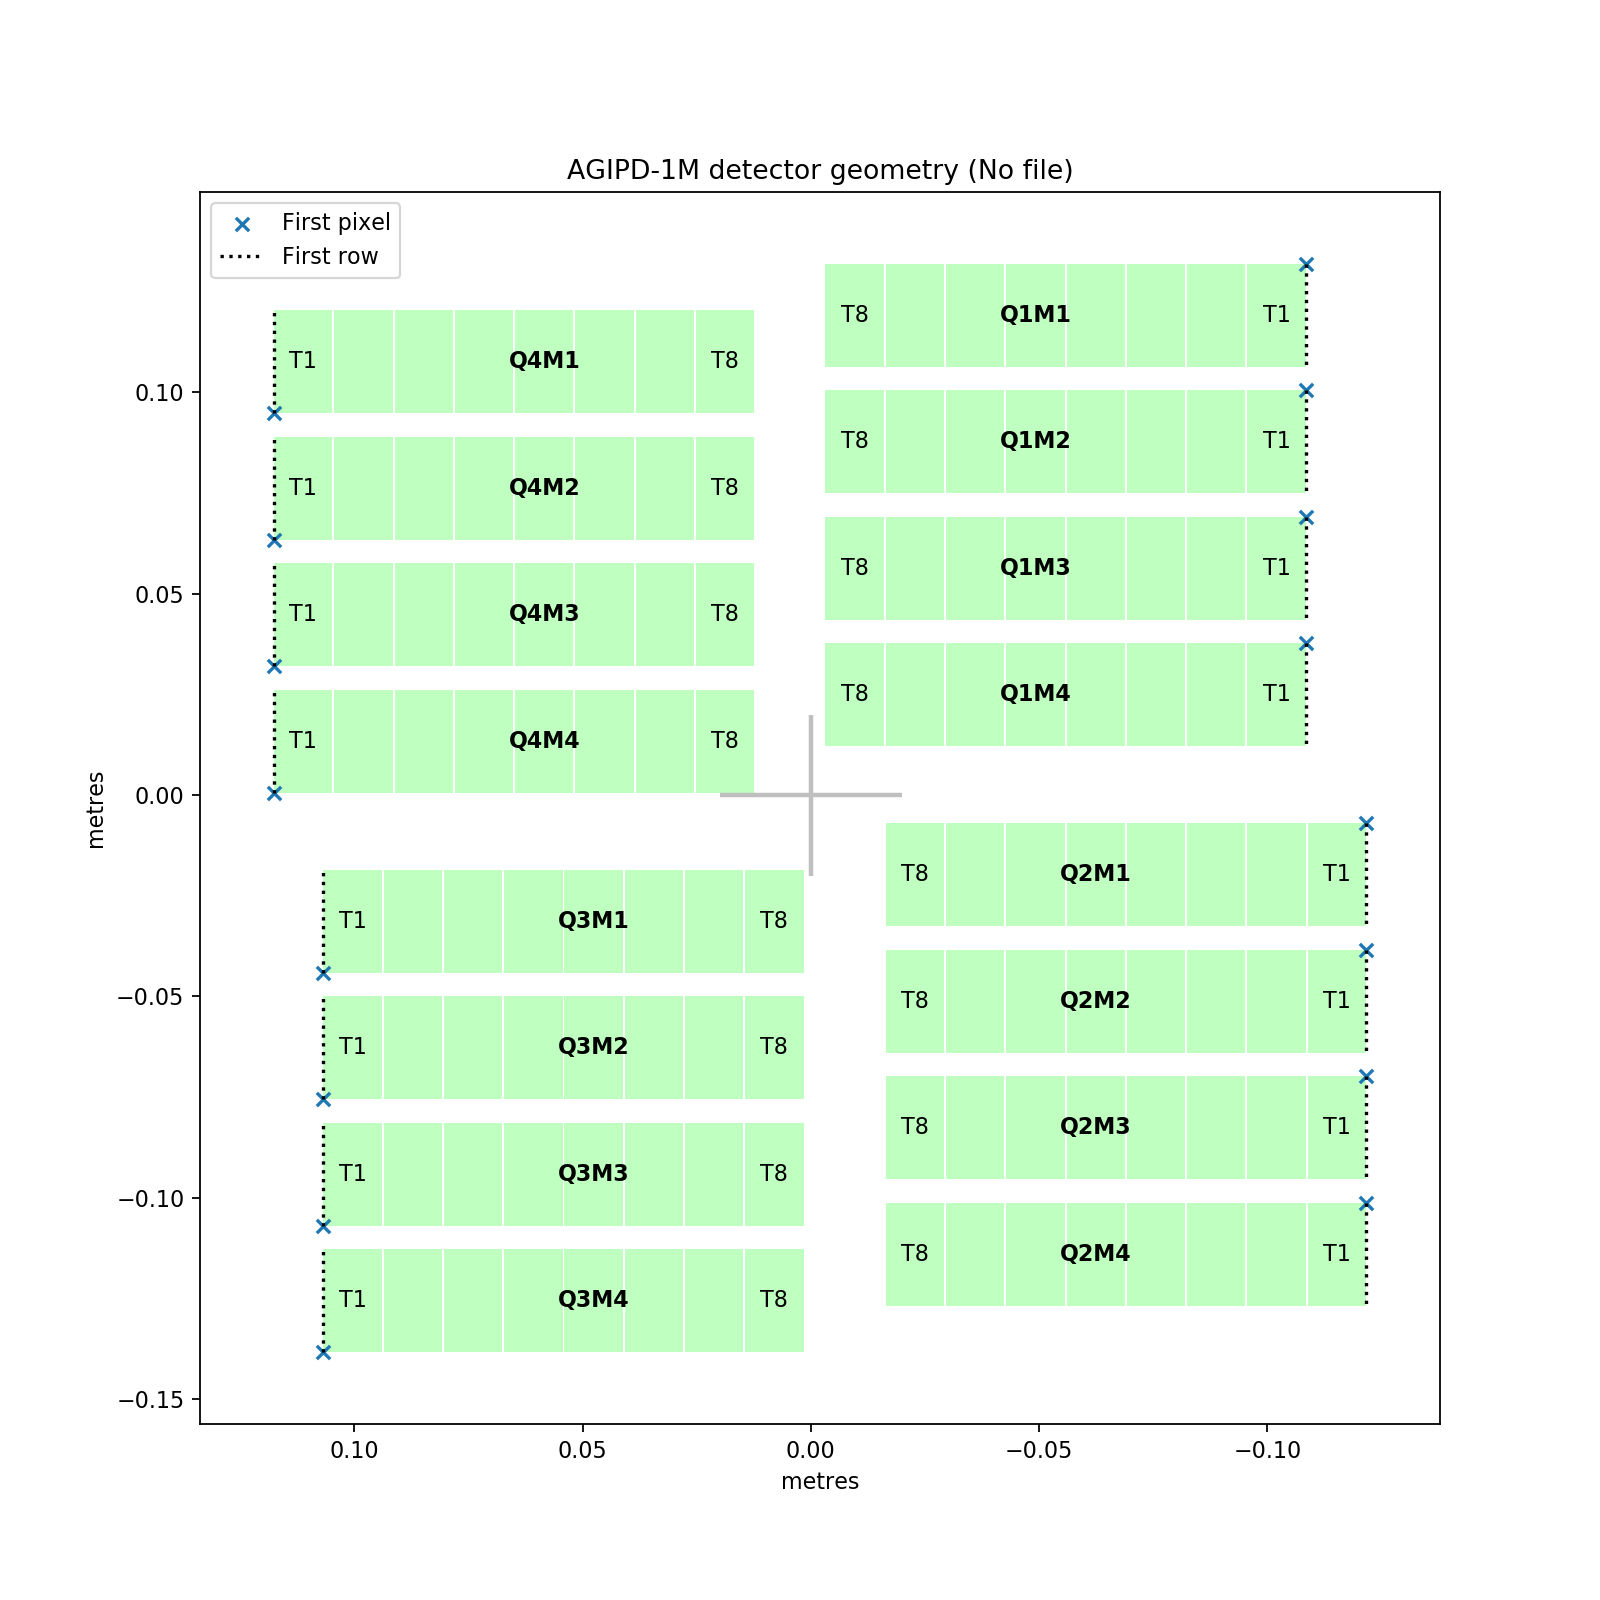

(16, 512, 128)

In [7]:
#---generate 16 points in array coordinates.

# Place one point in each module
module_no = np.arange(0, 16)

# For AGIPD, slow-scan is the x dimension, increasing from the edges towards the centre
slow_scan = np.linspace(10, 500, num=16)
fast_scan = np.full(fill_value=40.1, shape=16)  # Fixed y position in each module



#---convert these array positions into physical coordinates. 

positions = geom.data_coords_to_positions(module_no, slow_scan, fast_scan)
print("positions.shape =", positions.shape)  # (point, x/y/z)

ax = geom.inspect(axis_units='m')      # Show plot

px = positions[:, 0]
py = positions[:, 1]

pixpos = geom.get_pixel_positions()
px, py, pz = np.moveaxis(pixpos, -1, 0)  # Separate x, y, z coordinates
px.shape  # (modules, slow scan, fast scan)

In [10]:
def visualise_mask(mask_arr):
    return geom.plot_data(
        # converting to float allows gaps to be distinguished as NaN.
        mask_arr.astype(float), colorbar=None, axis_units='px'
    )

rect_mask = (-476 < px/200e-6) & (px/200e-6 < -412) & (125 < py/200e-6) & (py/200e-6 < 141)

correct_mean_img = ~rect_mask * mean_image

<IPython.core.display.Javascript object>


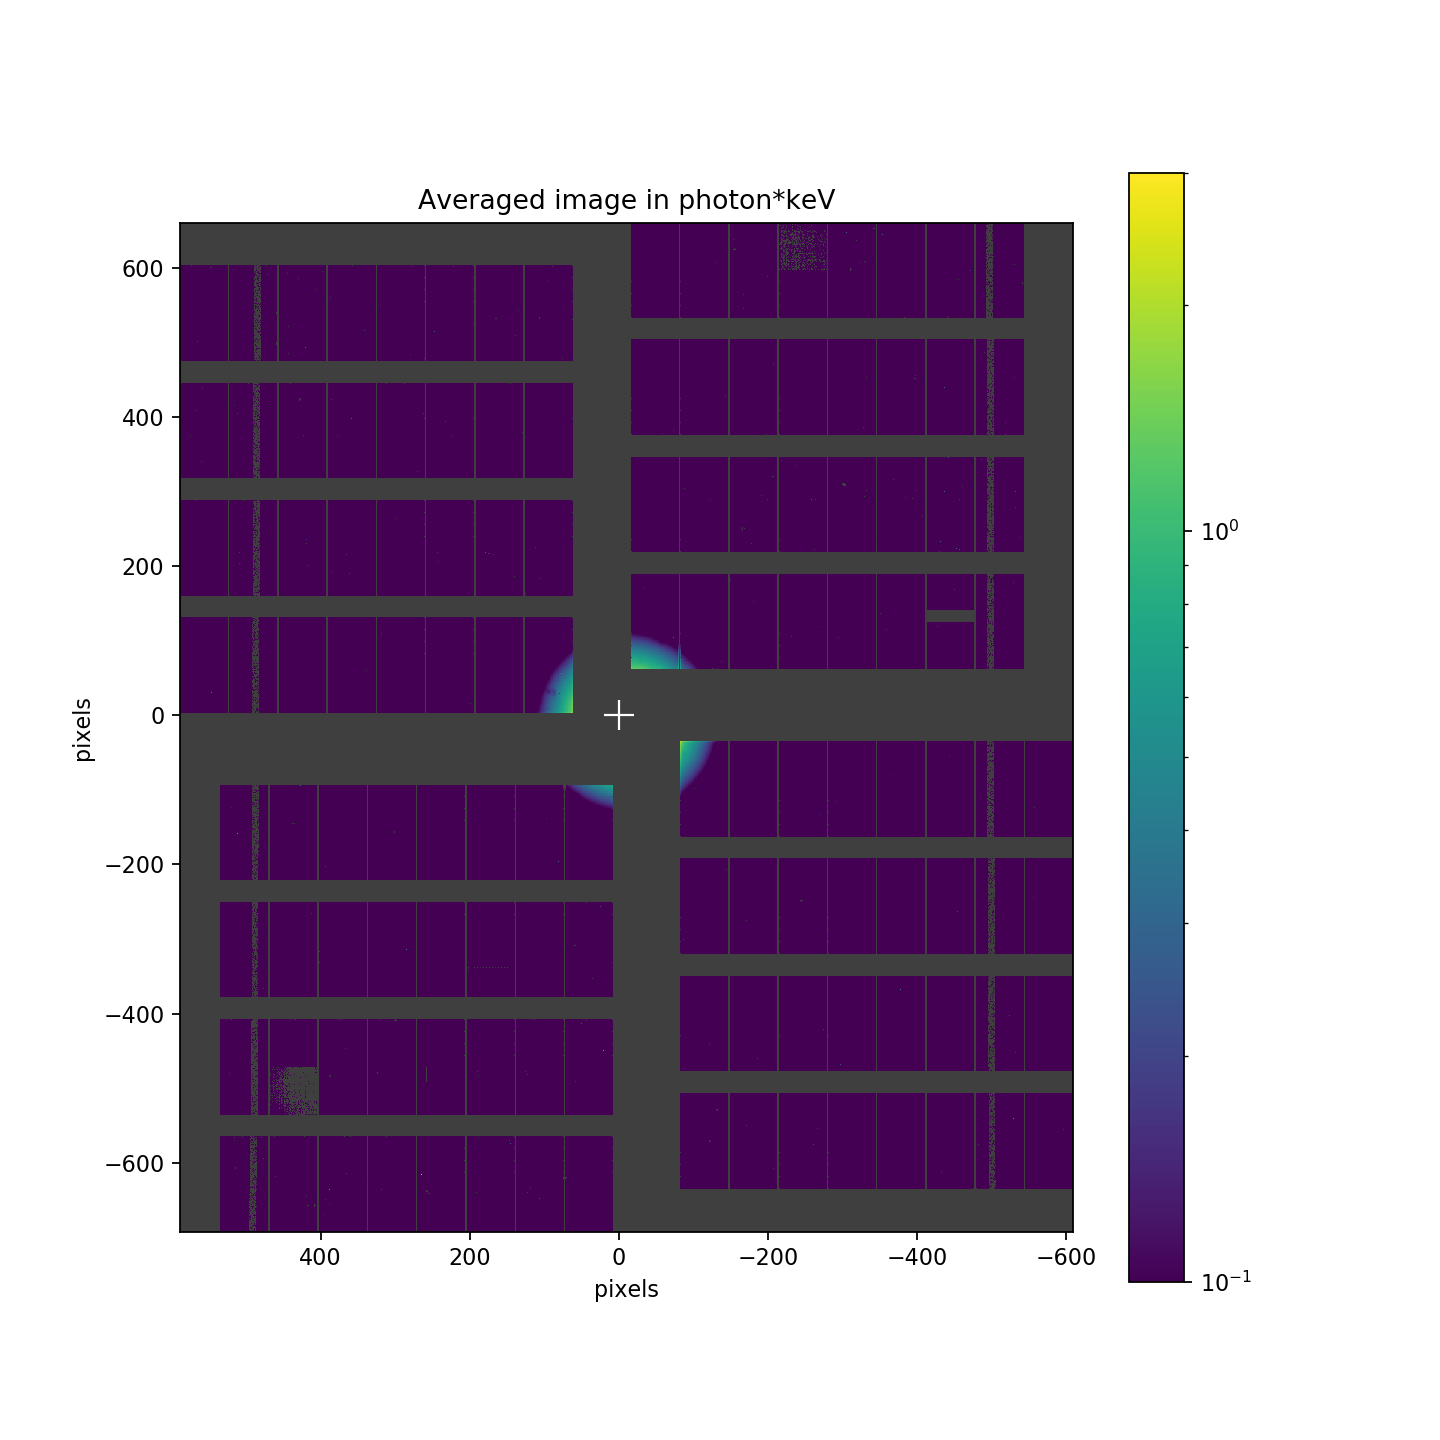

In [11]:
geom.plot_data_fast(correct_mean_img, figsize=(9, 9),norm = LogNorm(vmin = 1e-1, vmax = 3e0
                                                                ))
plt.title('Averaged image in photon*keV')
plt.savefig('Averaged_image.jpeg') 

# Azimuthal Integration


<IPython.core.display.Javascript object>


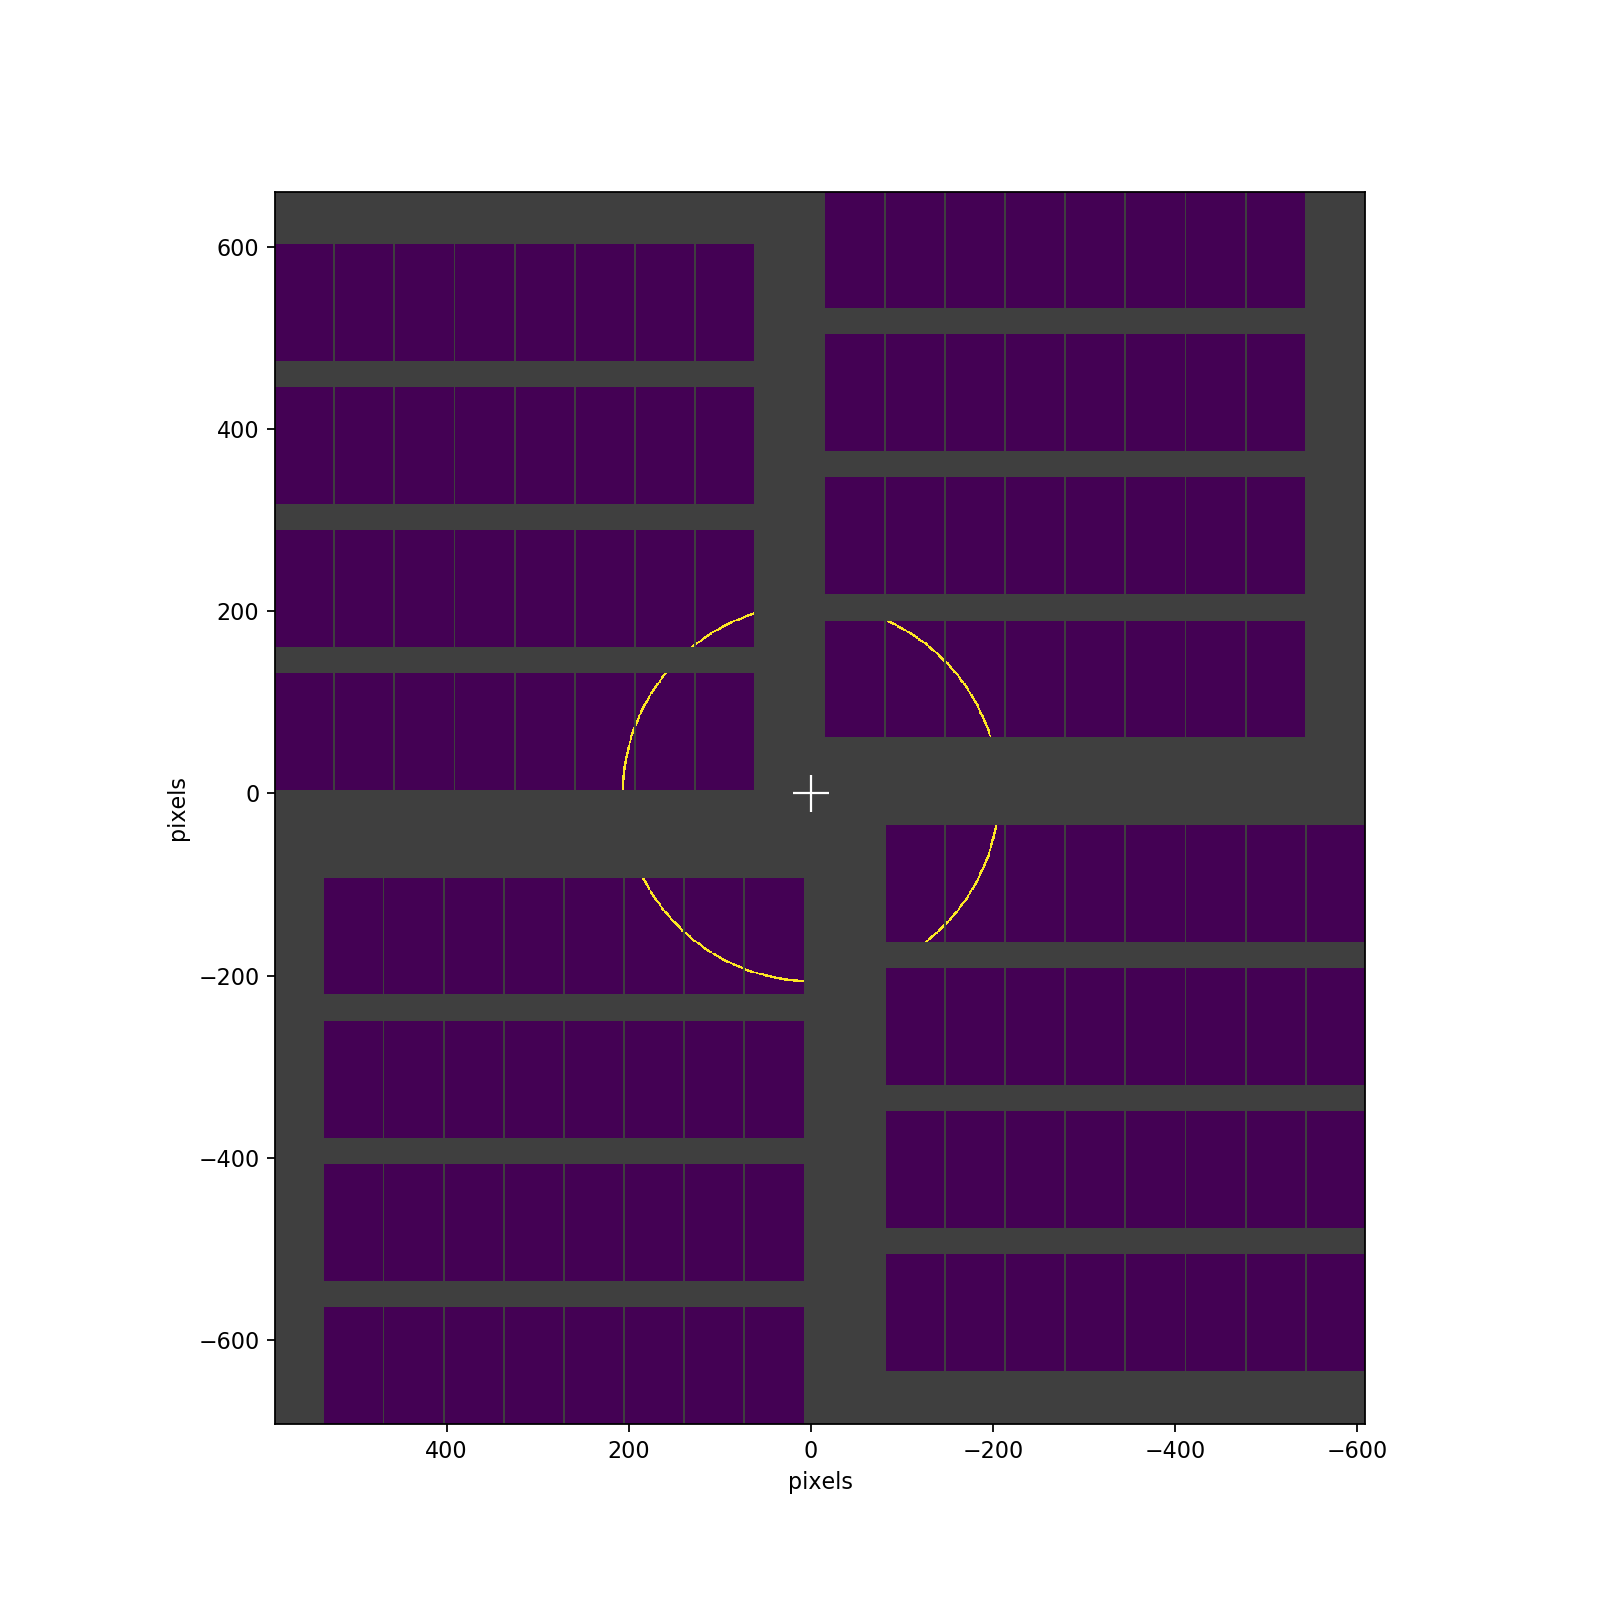

In [12]:
radius = np.sqrt(px**2 + py**2)

ring_mask = (0.0410 < radius) & (radius < 0.0415)
visualise_mask(ring_mask)

In [12]:
# check which module numbers the mask includes
modules_included = np.any(ring_mask, axis=(1, 2))
modules_included.nonzero()[0]

array([ 3,  4,  8, 14, 15])

In [13]:
# Mask AGIPD wide pixels

from extra_geom import agipd_asic_seams

# Get the mask, and repeat it for 16 modules
module_mask = agipd_asic_seams()
all_modules_mask = np.repeat(module_mask[np.newaxis], 16, axis=0)

#ax = visualise_mask(all_modules_mask)

# Zoom in to see the masked edges
#ax.set_xlim(0.04, 0)
#ax.set_ylim(0, 0.04)

More on masks here: https://extra-geom.readthedocs.io/en/latest/masks.html

In [14]:
# Mask wide pixels
from extra_geom import agipd_asic_seams

# Get the mask, and repeat it for 16 modules
module_mask = agipd_asic_seams()
all_modules_mask = np.repeat(module_mask[np.newaxis], 16, axis=0)

#ax = visualise_mask(all_modules_mask)

# Zoom in to see the masked edges
#ax.set_xlim(0.04, 0)
#ax.set_ylim(0, 0.04)

## PyFAI integrating

In [15]:
mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.figsize'] = (8, 6)

## Correct alignment / detector geometry

<IPython.core.display.Javascript object>


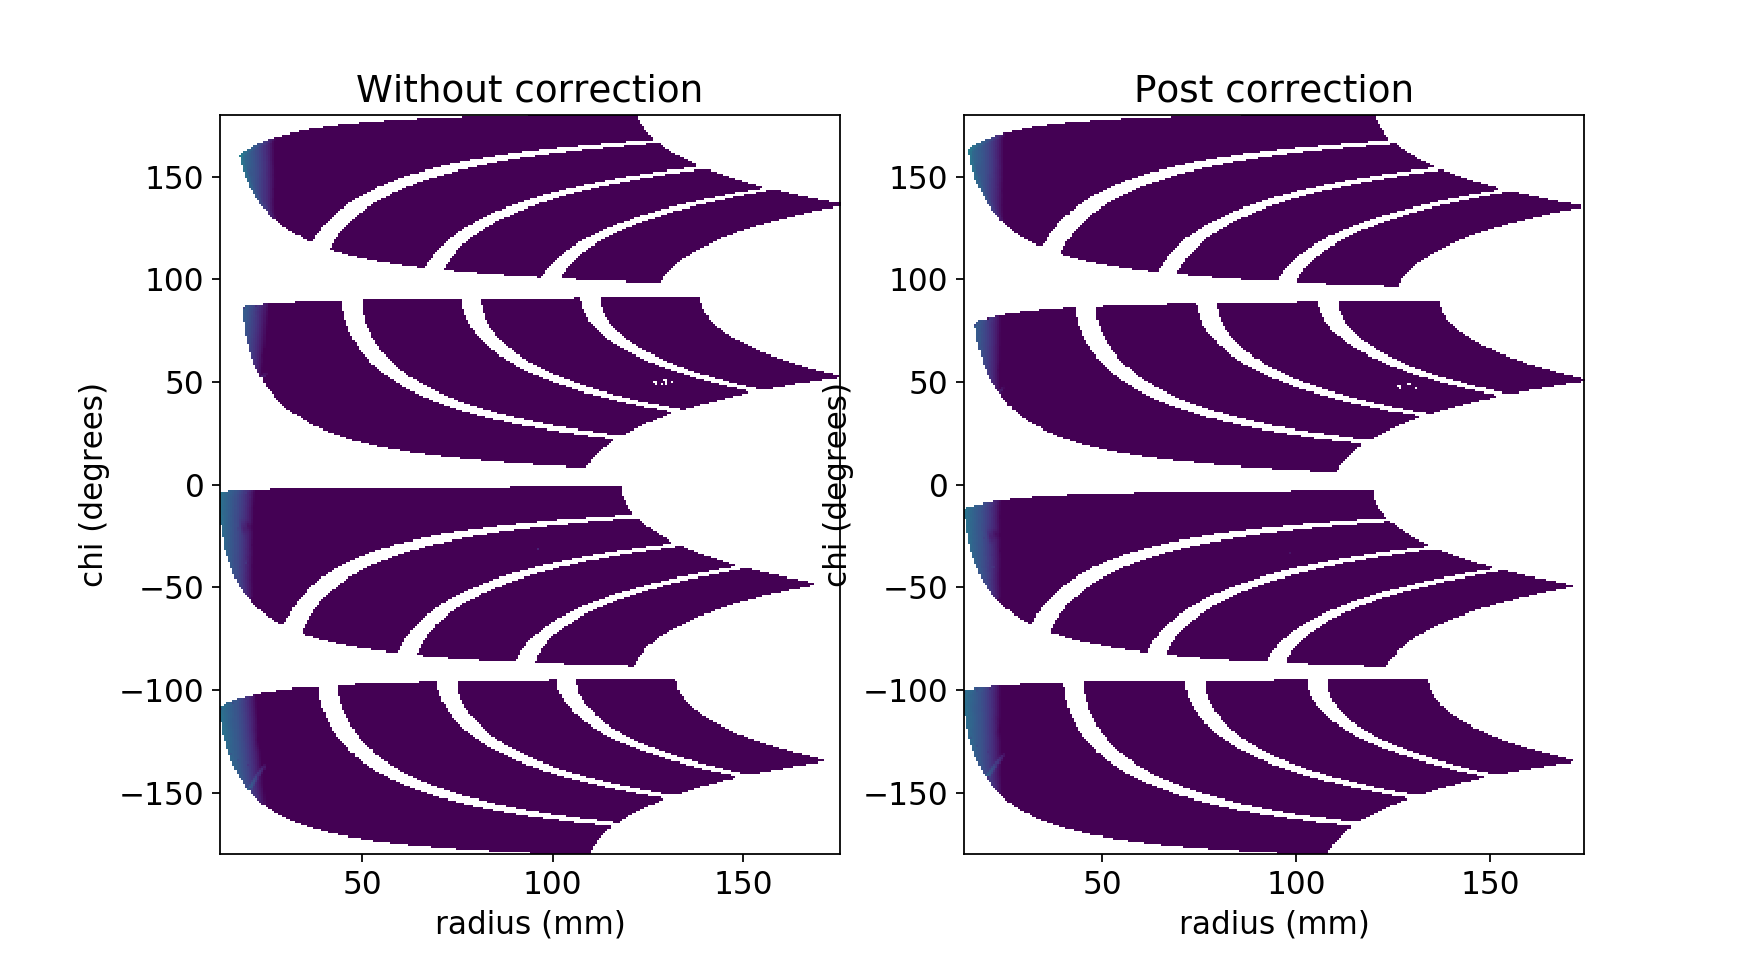

In [16]:
ai_old = AzimuthalIntegrator(
    detector=geom.offset((0, 0)).to_pyfai_detector(),
    dist=8,  # sample-detector distance (m)
    wavelength=(12.3984 / 9.3) * 1e-10  # wavelength (m)
)

ai_new = AzimuthalIntegrator(
    detector=geom.offset((0.0018, 0.0018)).to_pyfai_detector(),
    dist=8,  # sample-detector distance (m)
    wavelength=(12.3984 / 9.3) * 1e-10  # wavelength (m)
)

I_old, rint2d_old, chi_old = ai_old.integrate2d(
    mean_image.values.reshape(mean_image.shape[0]*mean_image.shape[1], mean_image.shape[2]),
    npt_rad=300,
    unit="r_mm",
    method=("pseudo", "histogram", "cython"),
)

I_new, rint2d_new, chi_new = ai_new.integrate2d(
    mean_image.values.reshape(mean_image.shape[0]*mean_image.shape[1], mean_image.shape[2]),
    npt_rad=300,
    unit="r_mm",
    method=("pseudo", "histogram", "cython"),
)


fig, (ax1, ax2) = plt.subplots(figsize=(11, 6), ncols=2)

old = ax1.imshow(I_old, aspect='auto',
          extent=(rint2d_old[0], rint2d_old[-1], -180, 180), norm = LogNorm(vmin = 1e-1, vmax = 1e2))
#fig.colorbar(old, ax=ax1)
ax1.set_xlabel('radius (mm)')
ax1.set_ylabel('chi (degrees)')
ax1.set_title('Without correction')

new = ax2.imshow(I_new, aspect='auto',
          extent=(rint2d_new[0], rint2d_new[-1], -180, 180), norm = LogNorm(vmin = 1e-1, vmax = 1e2))
#fig.colorbar(new, ax=ax2)
ax2.set_xlabel('radius (mm)')
ax2.set_ylabel('chi (degrees)')
ax2.set_title('Post correction')
fig.savefig('alignment.png')

<IPython.core.display.Javascript object>


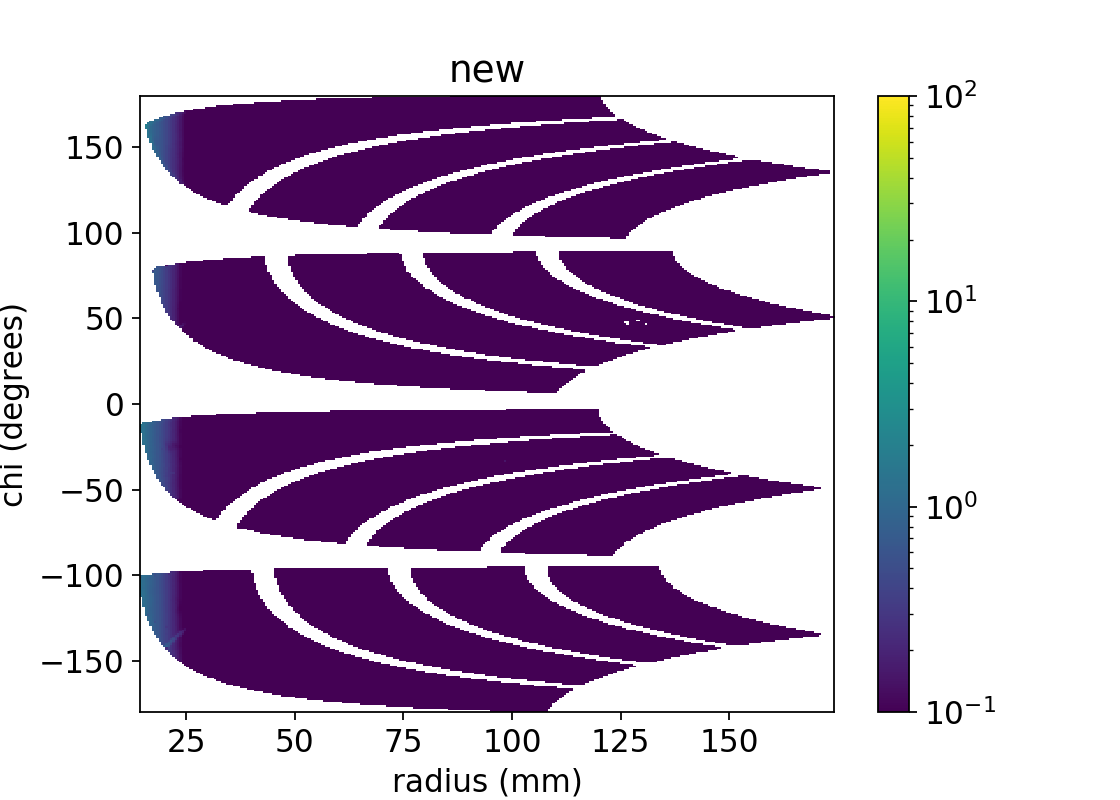

Text(0.5, 1.0, 'new')

In [17]:
fig, (ax2) = plt.subplots(figsize=(7, 5), ncols=1)
new = ax2.imshow(I_new, aspect='auto',
          extent=(rint2d_new[0], rint2d_new[-1], -180, 180), norm = LogNorm(vmin = 1e-1, vmax = 1e2))
fig.colorbar(new, ax=ax2)
ax2.set_xlabel('radius (mm)')
ax2.set_ylabel('chi (degrees)')
ax2.set_title('new')

In [23]:
len(q_space)

300

## Finding form factor

In [18]:
ai = AzimuthalIntegrator(
    detector=geom.offset((0.0018, 0.002)).to_pyfai_detector(),
    dist=8,  # sample-detector distance (m)
    wavelength=(12.3984 / 9) * 1e-10  # wavelength (m)
)

two_theta, I = ai.integrate1d(
    correct_mean_img.values.reshape(mean_image.shape[0]*mean_image.shape[1], mean_image.shape[2]),
    npt=300,
    unit="2th_deg",
)

r_int, I = ai.integrate1d(
    correct_mean_img.values.reshape(mean_image.shape[0]*mean_image.shape[1], mean_image.shape[2]),
    npt=300,
    unit="r_mm",
)


q, I = ai.integrate1d(
    correct_mean_img.values.reshape(mean_image.shape[0]*mean_image.shape[1], mean_image.shape[2]),
    npt=300,
    unit="q_A^-1",
)

<IPython.core.display.Javascript object>


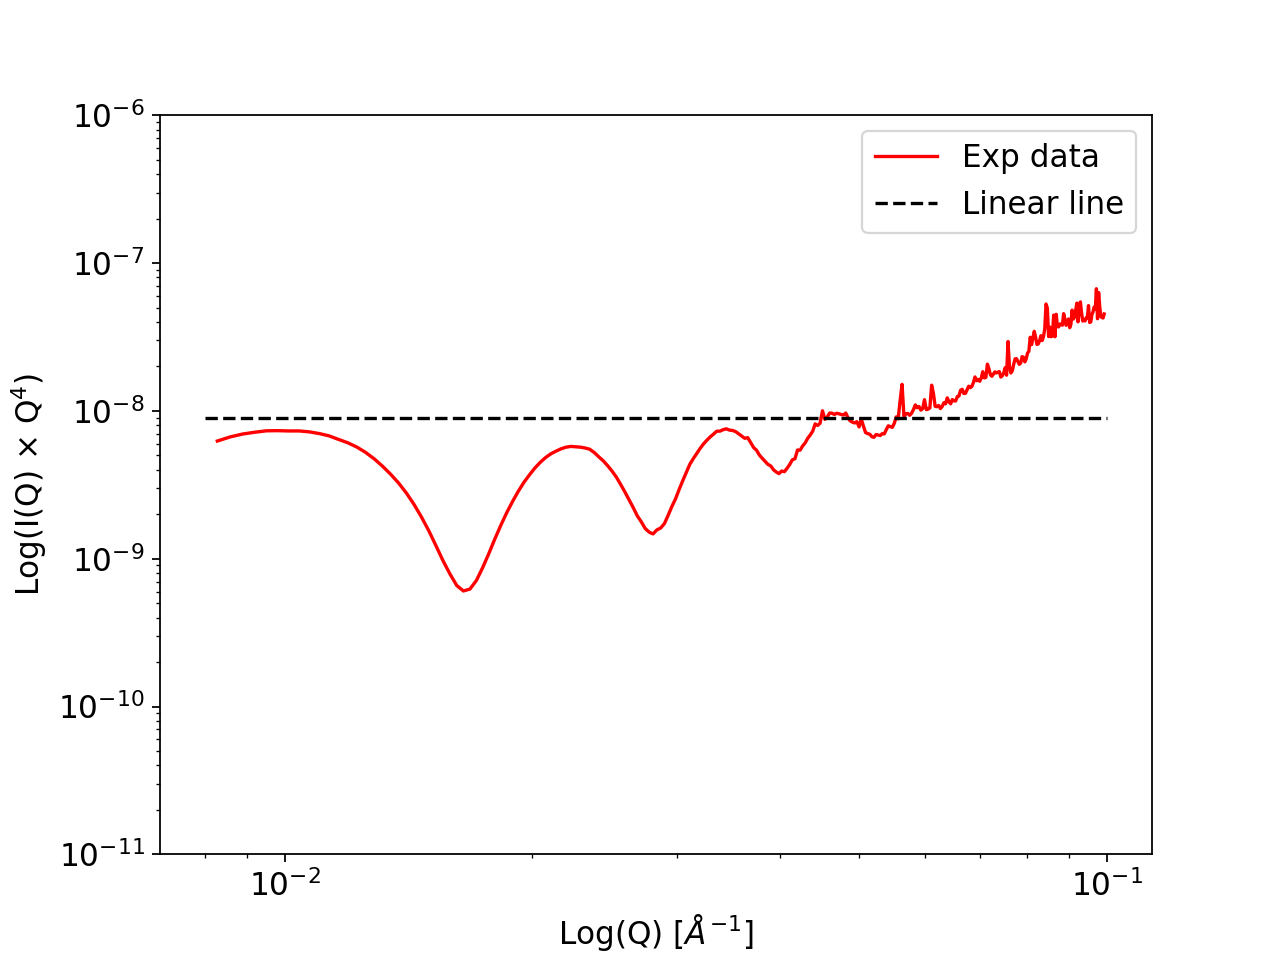

In [19]:
#---convert from real space to reciprocal space---# 

rint_m = r_int*1e-3    # real space axis unit in meters, d
L = 7.9               # detector/sample length in meters
wavelength_A = (12.3984 / 9)   # in armstrong
theta = two_theta / 2

q_space = ((4 * np.pi) / wavelength_A) * np.sin(np.radians(theta))  #A^{-1}

z = 50

radius = 4.5 / q[np.argmin(I[:z])]

def f(x, R, b):
    s = - (R**2 / 3)
    return s*(x**2) + b

def guinier(x, I, R):
    j = (x**2)*(R**2)/3
    m = np.exp(-j)
    return I*m

h = 0
k = 20

R = 250
L = 1.85


q_x = np.linspace(0,0.0003,100)


plt.figure()
plt.plot((q), (I)*(q**4),color='red', label='Exp data')
plt.plot(np.linspace(0.008, 0.1, 100),np.linspace(9*10**(-9), 9*10**(-9), 100),'--',color='black', label='Linear line')
#plt.plot((q**2)[h:k], f(q_space, R, L )[h:k], label='Guinier Approx.')
#plt.plot(q_space, I)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'Log(Q) [$\AA^{-1}$]')
plt.ylabel(r'Log(I(Q) $\times$ Q$^4$)')
plt.ylim((10**(-11),10**(-6)))
plt.legend()
plt.savefig('porod_before.png') 

<IPython.core.display.Javascript object>


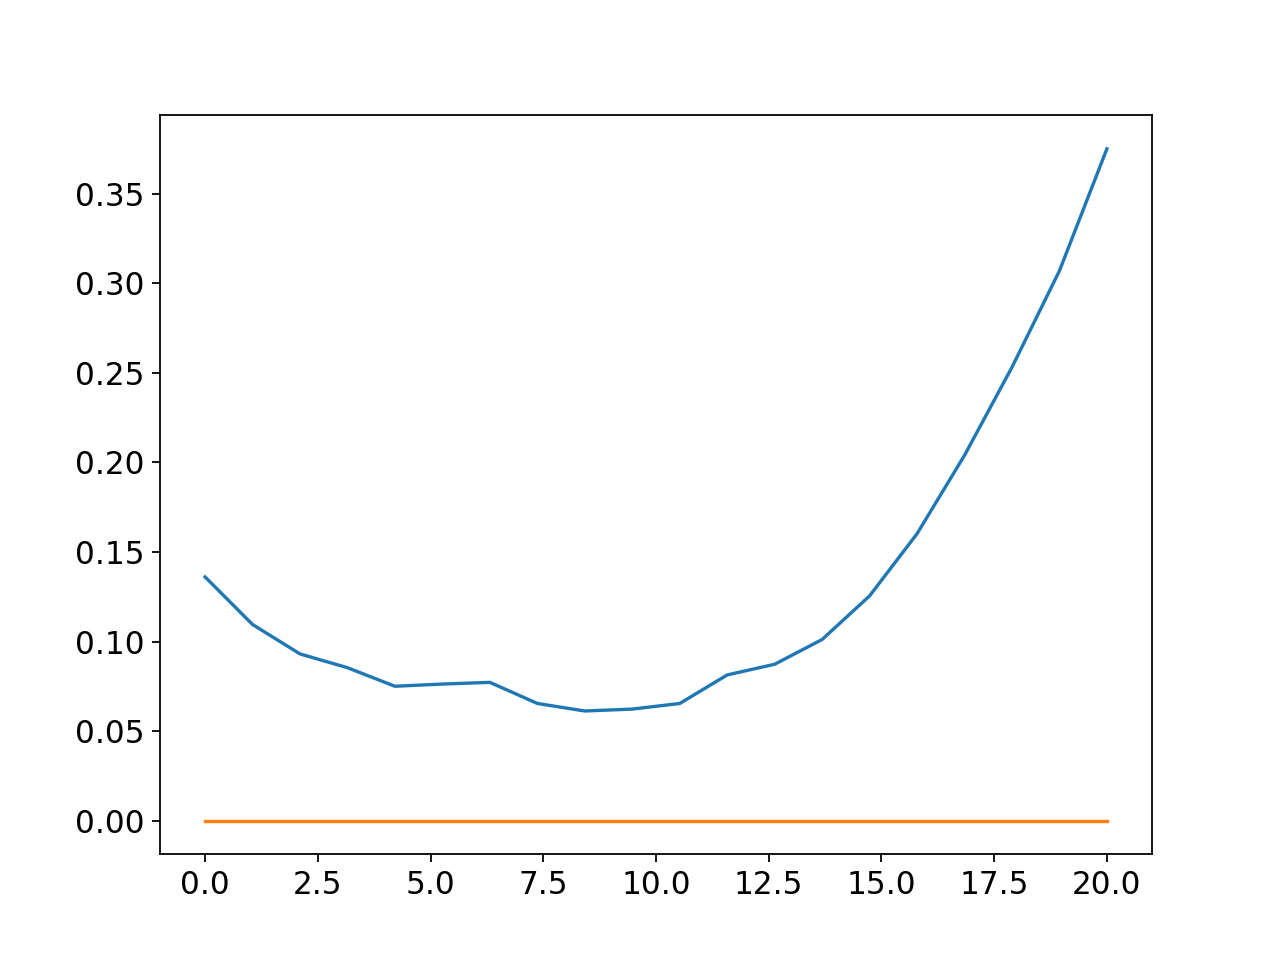

In [23]:
# residual 
plt.figure()
ey = f(q_space, R, L )[h:k]
oy = np.log(I)[h:k]
residual = ey - oy
x = np.linspace(0,len(ey),len(oy))
plt.plot(x, residual)
plt.plot(x, np.linspace(0,0,len(x)))

In [23]:
#radius  # in armstrong

<IPython.core.display.Javascript object>


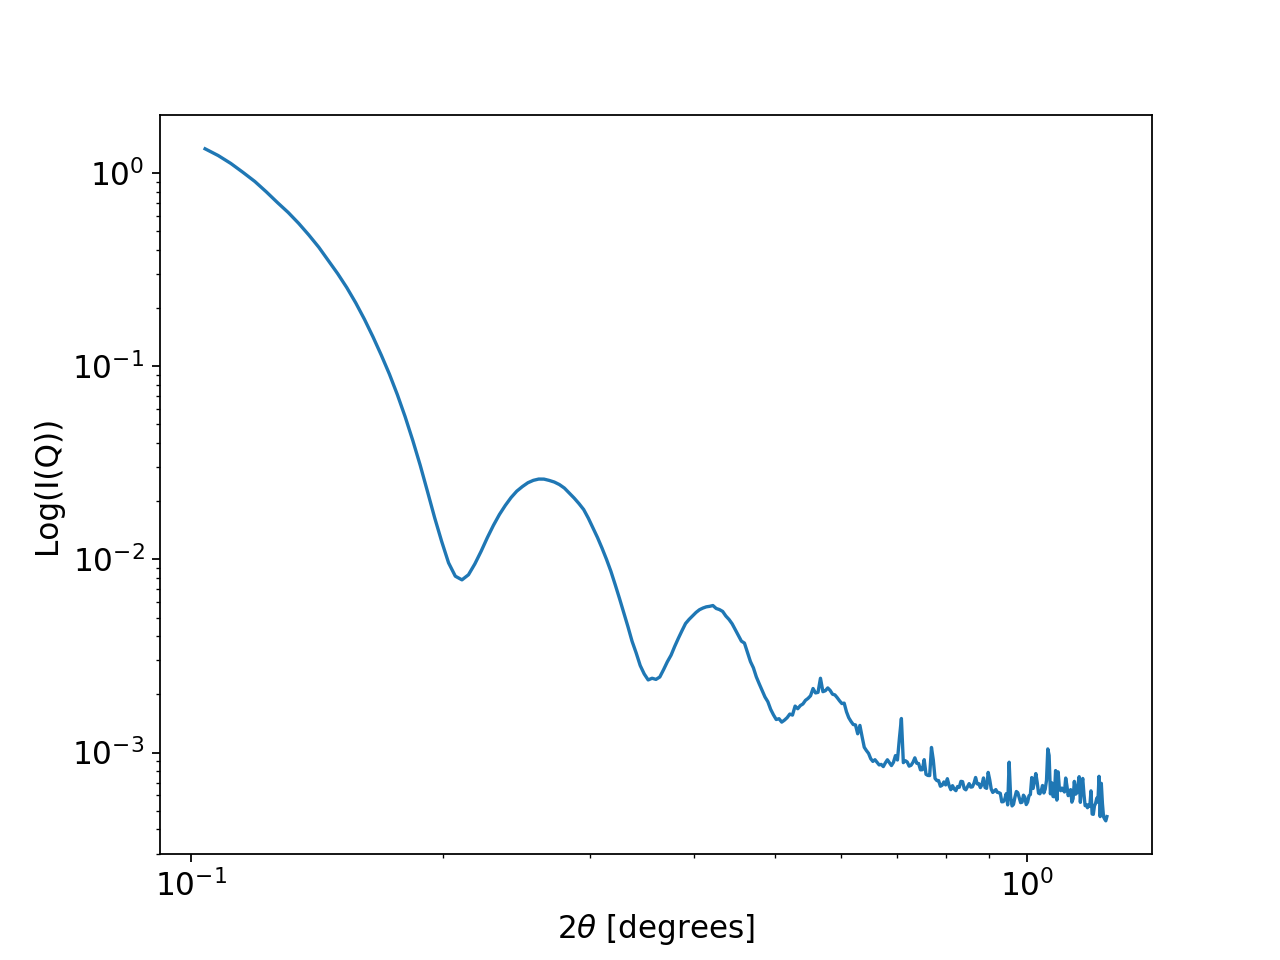

Text(0, 0.5, 'Log(I(Q))')

In [24]:
#---theta space---#

plt.figure()
plt.plot(two_theta, I)
#plt.plot(two_theta[:z], I[:z])
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'2$\theta$ [degrees]')
plt.ylabel(r'Log(I(Q))')

<IPython.core.display.Javascript object>


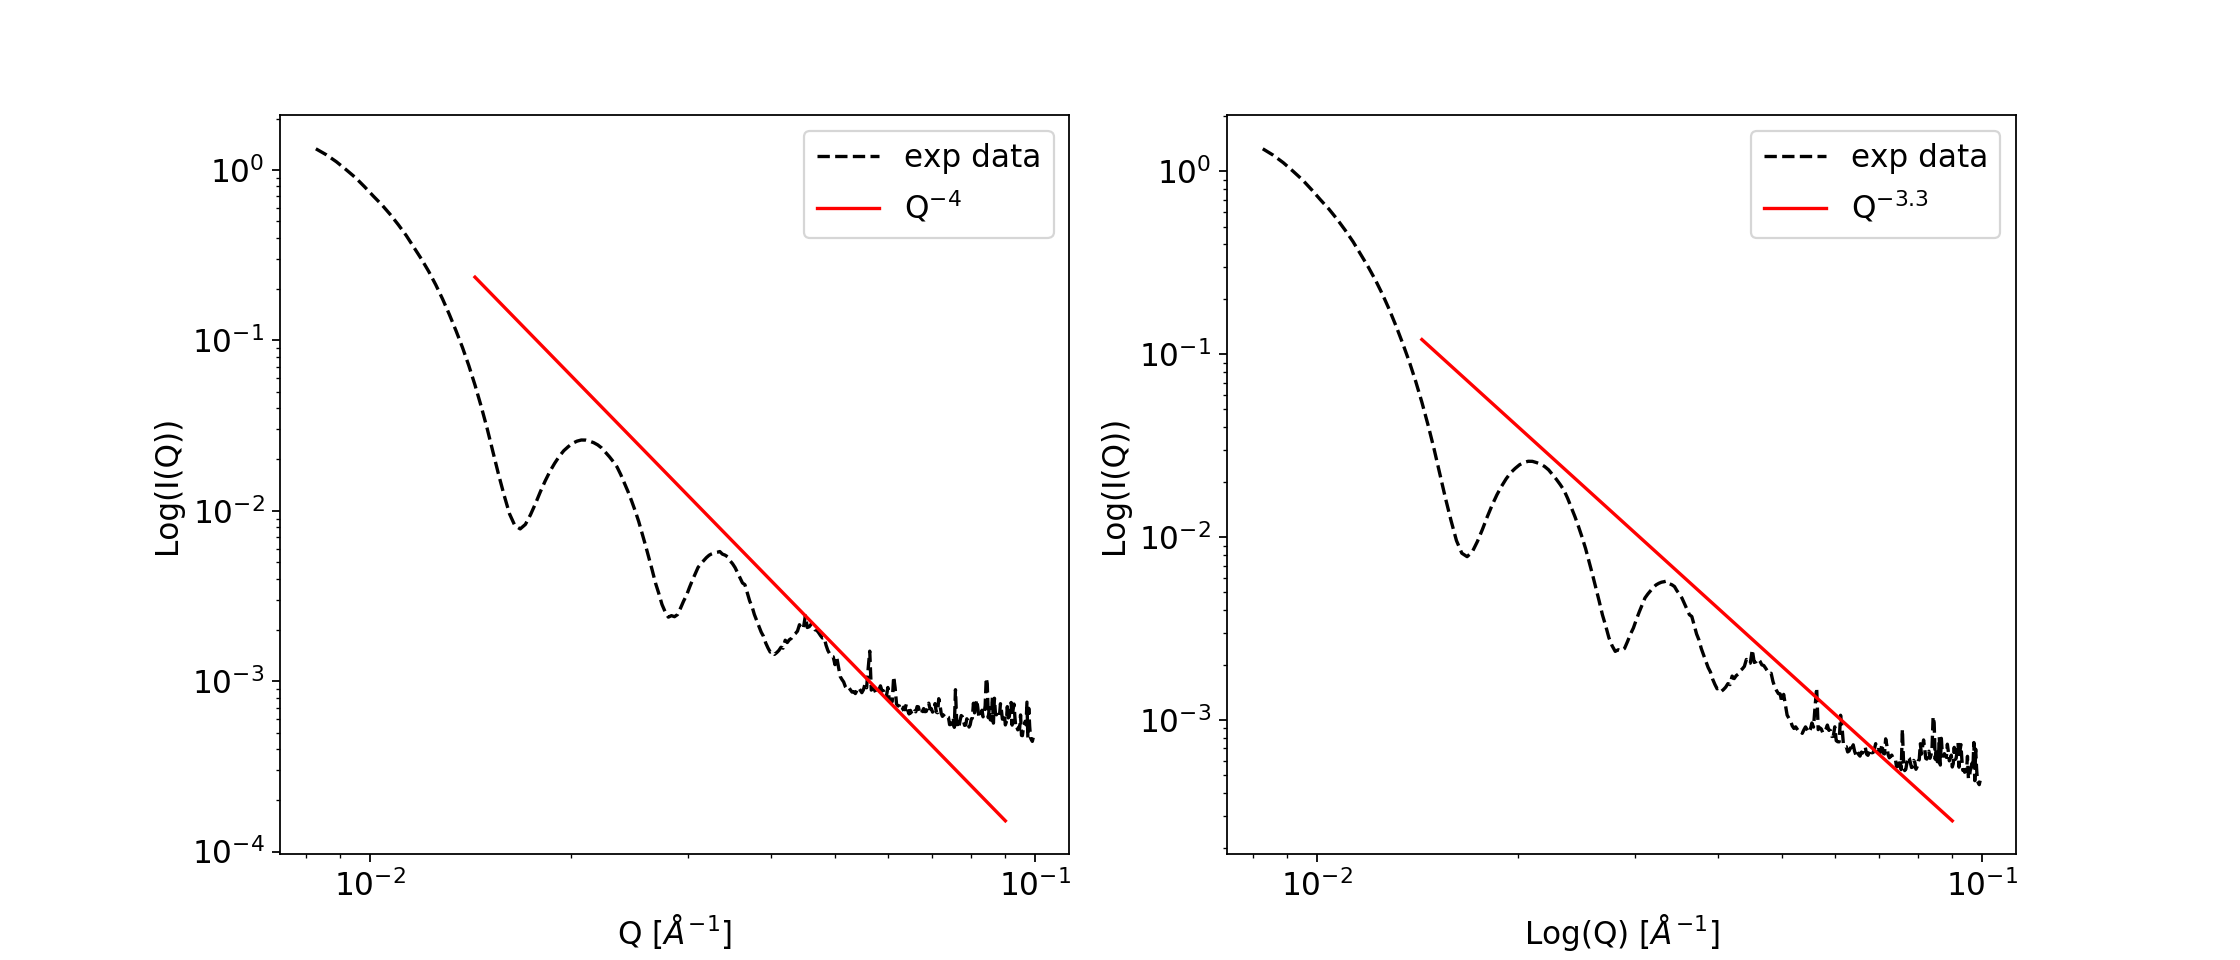

In [25]:
fig, (ax1, ax2) = plt.subplots(figsize=(14, 6), ncols=2)

ax1.plot(q, I,'--', label='exp data', color = 'black')
ax1.plot(q[20:270], (0.00000001)*1/q[20:270]**(4), color = 'red', label = r'Q$^{-4}$')
ax1.set_xlabel(r'Q [$\AA^{-1}$]')
ax1.set_ylabel(r'Log(I(Q))')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.legend()

ax2.plot(q, I,'--', label='exp data', color = 'black')
ax2.plot(q[20:270], (0.0000001)*1/q[20:270]**(3.3), color = 'red', label = r'Q$^{-3.3}$')
ax2.set_xlabel(r'Log(Q) [$\AA^{-1}$]')
ax2.set_ylabel(r'Log(I(Q))')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend()
fig.savefig('porod.png')


## Form Factor Fitting

In [45]:
def scattering_intensity(q, R, rho, scale, bkg):
    a = 3 / (q*R)**3
    b = np.sin(q*R) - q*R*np.cos(q*R)
    form_factor = (a * b)
    volume = (4/3) * np.pi * R**3
    I = form_factor**2 * volume**2 * rho**2
    return (I*(scale/volume) + bkg)

def gauss_pdf(x, mu, sigma) :
    """Gaussian"""
    return np.exp( -0.5 * (x-mu)**2 / sigma**2)

def Ngauss_pdf(x, mu, sigma) :
    """Non-normalized (extended) Gaussian"""
    N = 1/(np.sqrt(2*np.pi*(sigma**2)))
    return N * gauss_pdf(x, mu, sigma)

In [87]:
def smear(q_space, R, rho, scale, bkg, mu, sigma):
    gaussian = []
    
    for i in range(len(q_space)):
        g = Ngauss_pdf(q_space[i], mu, sigma[i])
        gaussian.append(g)
        
    Io = scattering_intensity(q_space, R, rho, scale , bkg) 
    smear = np.convolve(Io, gaussian, 'same')
    return smear, gaussian

def smear_any(I, q_space, mu, sigma):
    gaussian = []
    for i in range(len(q_space)):
        g = Ngauss_pdf(q_space[i], mu, sigma[i])
        gaussian.append(g)
    smear = np.convolve(I, gaussian, 'same')
    return smear

In [81]:
# resolution smearing
dtwo_theta = np.degrees(np.arctan((200*(10**(-6)) / 7.9)))

dq = ((2 * np.pi) / wavelength_A) * np.cos(np.radians(theta)) * dtwo_theta
res = dq/2.355

# wavelength smearing
dlambda = (12.3984 /0.0018)

dq2 = (-4*np.pi*np.sin(np.radians(theta)) / wavelength_A) * (18/9000)

In [83]:
dq[0], dlambda, wavelength_A, dq2[0]

(0.00661579580043345,
 6888.000000000001,
 1.3776000000000002,
 -1.655871428061694e-05)

In [71]:
from scipy.integrate import quad

mu = 0.0543
sigma = sig[0]
print('the integral is:', quad(Ngauss_pdf, 0, 0.099, args=(  mu, sigma))[0])
res[0], res[-1]*0.43, res[0]*0.43, dq[0]

the integral is: 1.0000000000000002


(0.002809255116956879,
 0.0012079087204566459,
 0.001207979700291458,
 0.00661579580043345)

<IPython.core.display.Javascript object>


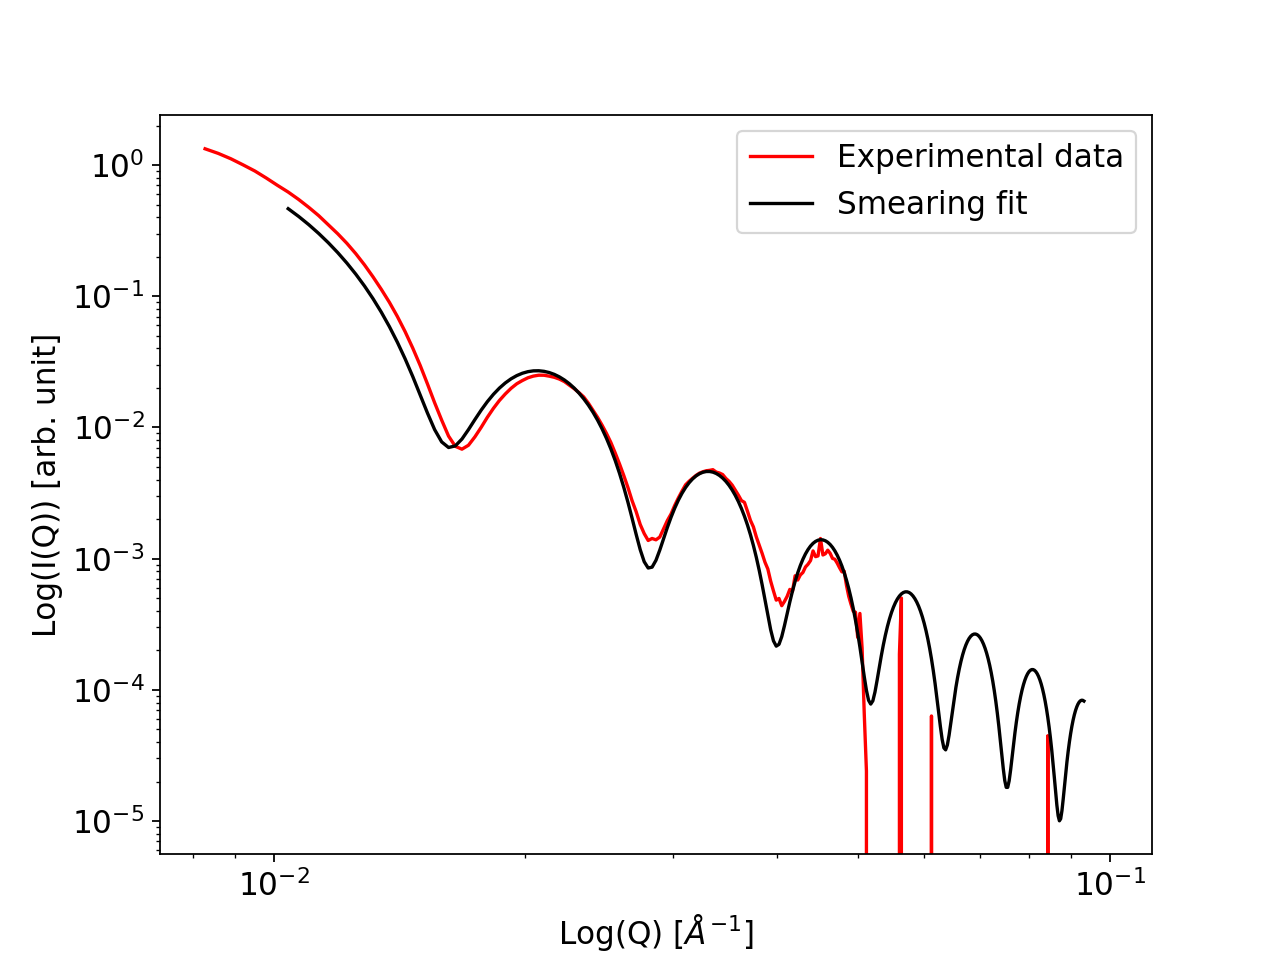

In [92]:
y_fit = scattering_intensity(q_space, R = 270, rho = 0.009, scale = 0.00057, bkg= 0.000) 
y_smear = smear_any(y_fit, q_space, mu= 0.0531, sigma = sig*0.43)
y_smear = smear(q_space, R = 267, rho = 0.009, scale = 0.00057, bkg = 0.000, mu = 0.0531, sigma = sig*0.43)
ix = y_smear[0]/3000
#y_smear2 = smear_any(ix, q_space, mu= 0.0531, sigma = dq2)

fig,ax=plt.subplots()
ax.plot(q_space, (I-10**(-3)), '-',color='red', label='Experimental data')
#ax.plot(q_space[:], y_fit[:], '--',label='Monodisperse fit', color = 'black')
ax.plot(q_space[7:-20], y_smear[7:-20]/3000, color='black',label='Smearing fit')
ax.plot(q_space[7:-20], y_smear2[7:-20]/3000, color='black',label='Smearing fit')



ax.set_yscale('log')
ax.set_xlabel(r'Log(Q) [$\AA^{-1}$]')
ax.set_ylabel(r'Log(I(Q)) [arb. unit]')
ax.set_xscale('log')
ax.legend()


plt.show()
plt.savefig('smear_SAXSmonofit(x).png')



## Exporting 

In [32]:
dat = np.array([q_space, y, I])

dat = dat.T

np.savetxt('mono_data.txt', dat, delimiter = ',')

NameError: name 'y' is not defined

In [101]:
import pandas as pd

data = pd.read_csv('mono_data.txt', sep = ',')
data.columns = ['q-space', 'fit', 'exp']

q_space = data['q-space']
y = data['fit']
exp = data['exp']

## Statistical fitting

In [33]:
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit
import sys    
from scipy import stats

In [41]:
sys.path.append('/External_Functions')
from ExternalFunctions import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax 

sig = res

(array([173.76875046, 174.09757775, 174.40599559, 174.69382697,
        174.96089452, 175.20702084, 175.43202894, 175.63574279,
        175.81798805, 175.97859284, 176.1173886 , 176.23421099,
        176.32890084, 176.40130508, 176.45127767, 176.47868052,
        176.48338429, 176.4652692 , 176.42422568, 176.36015501,
        176.27296975, 176.16259416, 176.02896447, 175.87202898,
        175.69174817, 175.48809459, 175.26105271, 175.01061871,
        174.73680009, 174.43961538, 174.11909362, 173.77527393,
        173.40820507, 173.01794488, 172.60455983, 172.16812459,
        171.70872159, 171.22644062, 170.72137854, 170.19363903,
        169.64333235, 169.07057527, 168.47549095, 167.85820902,
        167.21886563, 166.55760358, 165.87457253, 165.16992926,
        164.44383792, 163.69647039, 162.92800657, 162.13863474,
        161.32855192, 160.49796419, 159.64708697, 158.77614536,
        157.88537433, 156.97501894, 156.04533448, 155.09658658,
        154.12905121, 153.14301467, 152.

In [57]:
chi2_object = Chi2Regression(smear, q_space[10:100], I[10:100])
chi2_object.errordef = 1.0 

Npoints = len(I[10:100])                       # Set number of data points len(array)
Nvar = 4                         # Set number of varying parameters
Ndof = Npoints - Nvar                # Find degrees of freedom

minuit = Minuit(chi2_object, R = 270, rho = 0.005, scale = 0.0019, bkg = 0.0005, mu = 0.0543, sigma=res*0.43)
minuit.migrad()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [229]:
R_fit, rho_fit, scale_fit, bkg_fit = minuit.values[:]
R_err, rho_err, scale_err, bkg_err = minuit.errors[:]

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof)    # The chi2 probability given N degrees of freedom

xi = np.linspace(q_space.min(),q_space.max(),len(q_space))

fig, ax = plt.subplots(figsize=(10, 6))  # figsize is in inches

fit = lambda x: scattering_intensity(x, R_fit, rho_fit, scale_fit, bkg_fit)
ax.plot(xi, fit(xi), label='fit')
ax.plot(q_space, I, label='exp')
ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_ylim([10**(-5), 10])
ax.set_xlabel(r' Q[$\AA^{-1}$]')
ax.set_ylabel(r'Log(I(Q))')
ax.legend(loc='lower left')


d = {'R':[R_fit, R_err],
     'Δ⍴': [rho_fit, rho_err],
     'scale': [scale_fit, scale_err],
     'bkg': [bkg_fit, bkg_err],
     'Chi2':     Chi2_fit,
     'p-value': Prob_fit,
    }
text = nice_string_output(d, extra_spacing=2, decimals=4)
add_text_to_ax(0.55, 0.95, text, ax, fontsize=14)                  #Location of text:  63% Right, 95% Top 
fig.tight_layout()

ValueError: not enough values to unpack (expected 4, got 2)

# Polydisperse stats fit

In [47]:
def G(y):
    a = (120 + 1)**2
    b = (120 + 1)**2 + y**2
    return a / b

def F(y):
    return np.arctan(y / (120+1))

def Q(x):
    term1 = (1/2)*np.cos((120+1)*F(2*x))
    term2 = x * G(2*x)**(1/2) * np.sin((120+2)*F(2*x))
    term3 = (1/2) * x**2 * ((120+2)/(120+1)) * G(2*x) * np.cos((120+3)*F(2*x)) 
    return - term1 - term2 + term3

def polydisperse(x):
    frac = (9 * m.factorial(120) * ((120+1)**6)) / ((x**6) * (m.factorial(120+6)))
    brac = 1/2 + (1/2)*((120+2)/(120+1))*(x**2) + (G(2*x)**((1/2)*(120+1)) * Q(x))
    return frac * brac

def poly_intensity(q, R, rho, scale, bkg):
    qr = q*R
    I = polydisperse(qr) * rho**2 * scale     # scale includes N and geometric stuff. 
    return I + bkg



In [33]:
chi2_object = Chi2Regression(scattering_intensity, q_space[:210], I[:210])
chi2_object.errordef = 1.0 

Npoints = len(I)                       # Set number of data points len(array)
Nvar = 4                         # Set number of varying parameters
Ndof = Npoints - Nvar                # Find degrees of freedom

minuit = Minuit(chi2_object, R = 265, rho = 0.0025, scale = 0.0002, bkg= 0.00013) 
minuit.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 0.004759                   │       Ncalls = 136 (136 total)       │
│ EDM = 9.23e-05 (Goal: 0.0002)    │               up = 1.0               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R     │    270    │    70     │            │            │         │         │       │
│ 1 │ rho   │   0.01    │   0.27    │            │            │         │         │       │
│ 2 │ scale │   0.00    │   0.01    │            │            │         │         │       │
│ 3 │ bkg   │   0.00    │   0.07    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

# Polydisparity

In [48]:
def smear2(q_space, R, rho, scale, bkg, mu, sigma):
    gaussian = []
    
    for i in range(len(q_space)):
        g = Ngauss_pdf(q_space[i], mu, sigma[i])
        gaussian.append(g)
        
    Io = poly_intensity(q_space, R, rho, scale, bkg)
    smear = np.convolve(Io, gaussian, 'same')
    return smear, gaussian

<IPython.core.display.Javascript object>


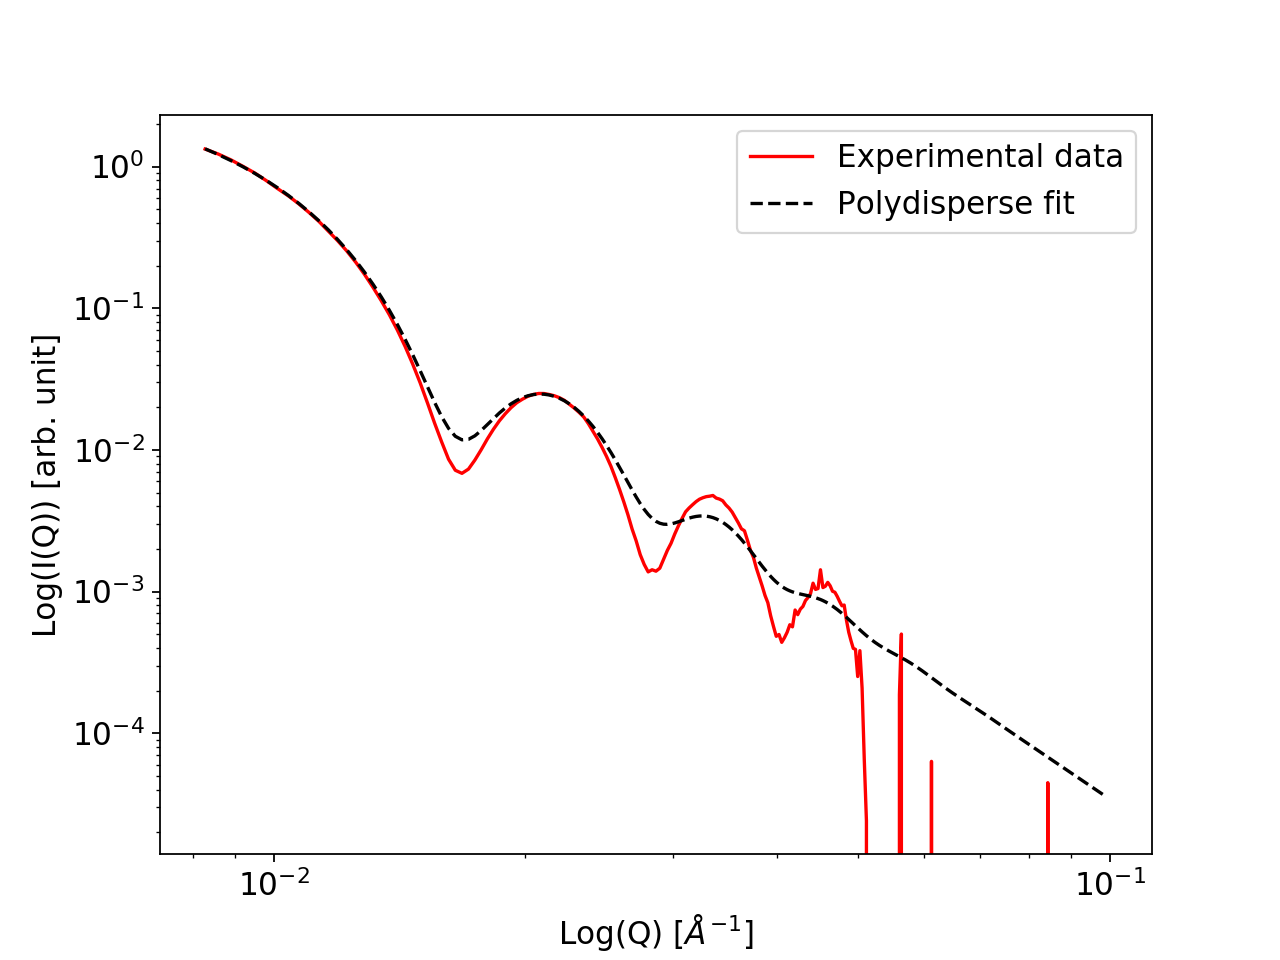

In [49]:
z = 120
R = 263
rho = 0.01
bkg = 0.0007
scale = 42000



#III = poly_intensity(q_space, z = 160, R = 265, rho = 0.003, scale = 1100000, bkg = 0)
II = poly_intensity(q_space, R = 265, rho = 0.01, scale = 42000, bkg = 0)
II_smear = smear2(q_space, R = 265, rho = 0.01, scale = 42000, bkg= 0, mu = 0.0531, sigma = sig*0.43)

fig,ax=plt.subplots()

ax.plot(q_space, (I-10**(-3)), '-',color='red', label='Experimental data')
ax.plot(q_space[:], II[:], '--',label='Polydisperse fit', color = 'black')
#ax.plot(q_space[7:-20], II_smear[0][7:-20]/3000, color='black',label='Smearing fit')



ax.set_yscale('log')
ax.set_xlabel(r'Log(Q) [$\AA^{-1}$]')
ax.set_ylabel(r'Log(I(Q)) [arb. unit]')
ax.set_xscale('log')
ax.legend()

plt.show()
plt.savefig('polyfit.png')

In [35]:
from scipy.optimize import curve_fit

#init_vals = np.array([263, 0.01, 42000, 0.0007])
init_vals = np.array([R_fit, rho_fit, scale_fit, bkg_fit])


popt, pcov = curve_fit(scattering_intensity, q_space, II, p0 = init_vals)

In [38]:
def poly_intensity(q, R, rho, scale, bkg):
    qr = q*R
    I = polydisperse(qr) * rho**2 * scale     # scale includes N and geometric stuff. 
    return I + bkg

(array([2.68419459e+02, 1.39379900e-02, 2.49515894e-04, 1.19801075e-03]),
 array([[ 4.88292518e-02,  1.37126889e+01, -4.90965160e-01,
          5.95910067e-06],
        [ 1.37126931e+01, -2.84756483e+05,  1.01953393e+04,
         -7.22939851e-05],
        [-4.90965310e-01,  1.01953393e+04, -3.65030999e+02,
          2.58838391e-06],
        [ 5.95910071e-06, -7.22948322e-05,  2.58841424e-06,
          3.40392296e-08]]))

In [111]:

init_vals = np.array([263.0, 0.001, 42000.0, 0.0007])

popt, pcov = curve_fit(poly_intensity, q_space, II, p0 = init_vals)


TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

error: Result from function call is not a proper array of floats.

In [62]:
init_vals.flatten().shape, init_vals.shape, II.shape

((4,), (4,), (300,))

In [22]:
def fit(z, r_a, r):
    fac = 1/m.factorial(z)
    one = r**z
    two = ((z+1)/r_a)**(z+1)
    three = np.exp(-((z+1)*(r/r_a)))
    return fac * one * two * three

z = 120
ro = 252
r = np.linspace(150,400,100)
y = fit(z, ro, r)
yy = fit(80, ro, r)
yyy = fit(60, ro, r)
N = max(y)
g = Ngauss_pdf(r, 0.0175, 250, 22)


<IPython.core.display.Javascript object>


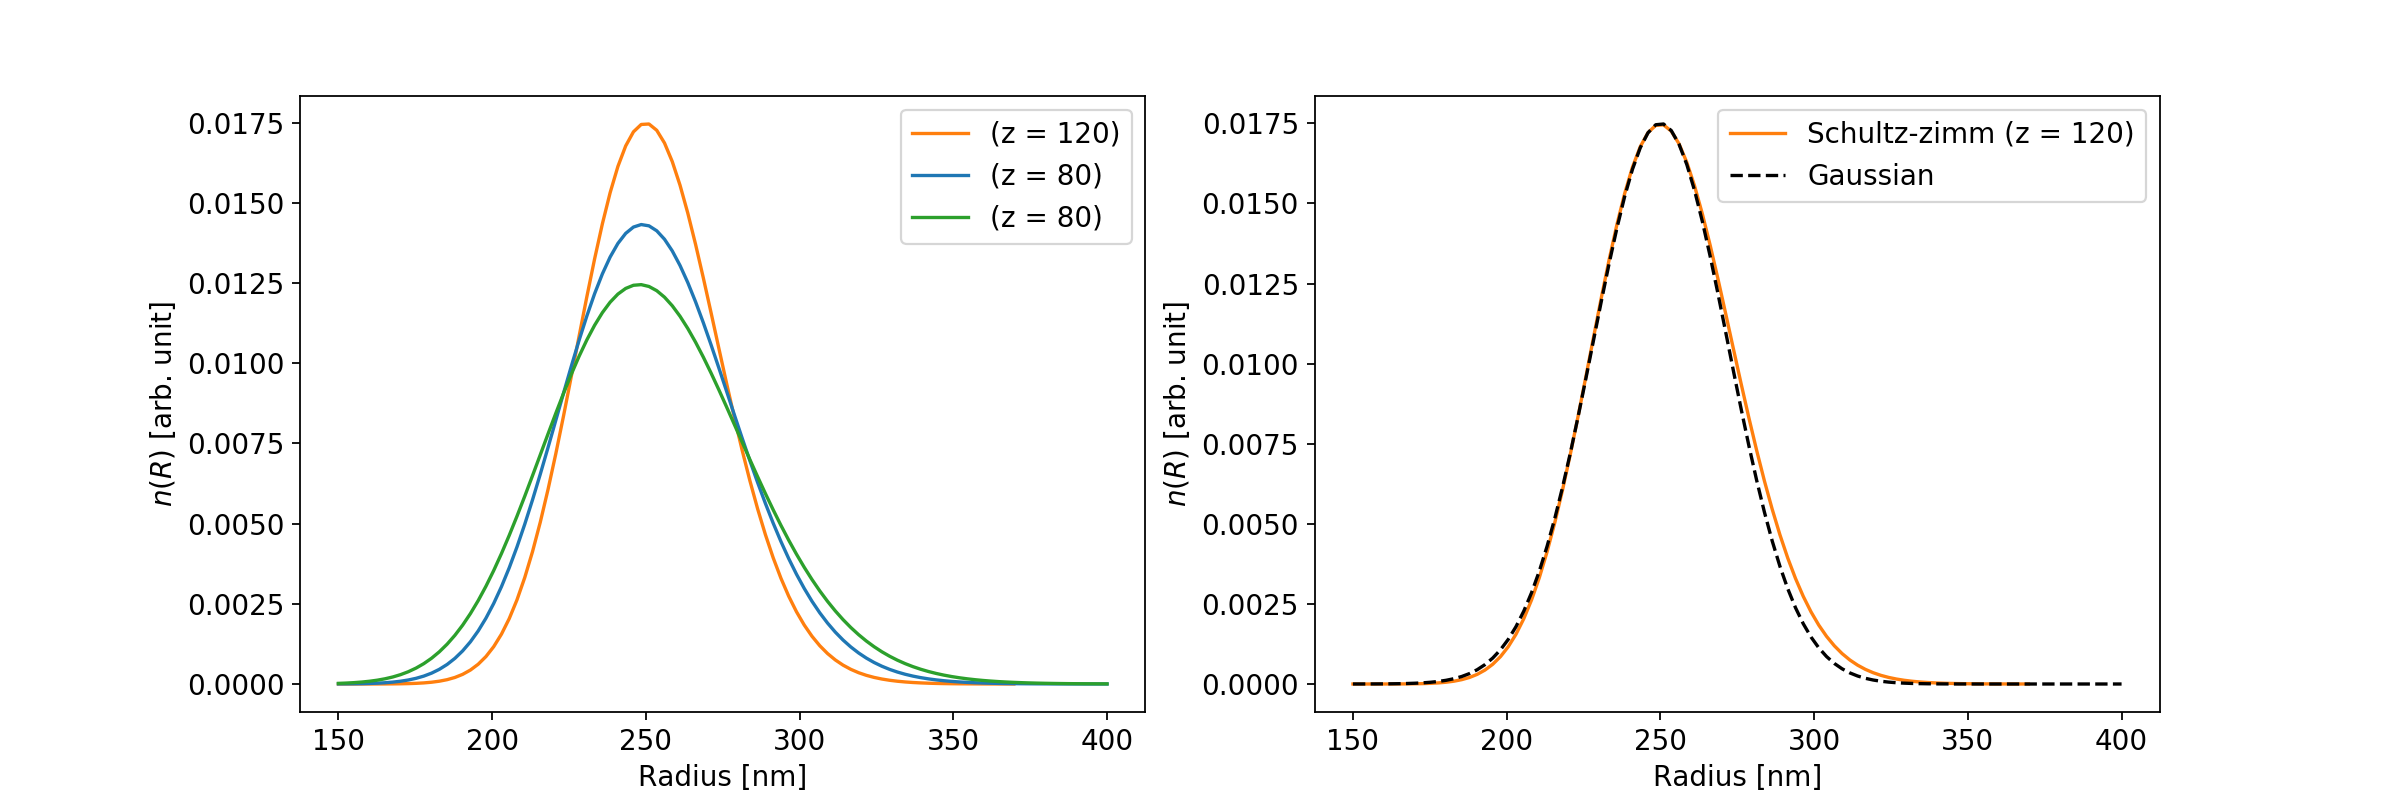

In [13]:
fig, (ax1, ax2) = plt.subplots(figsize=(15 , 5), ncols=2)

plt.rcParams.update({'font.size': 12.5})

ax2.plot(r, y, label = 'Schultz-zimm (z = 120)', color = 'tab:orange')     
ax2.plot(r,g, '--', label = 'Gaussian', color = 'k')
    
ax1.plot(r, y, label = '(z = 120)', color='tab:orange')
ax1.plot(r, yy, label = '(z = 80)', color='tab:blue')
ax1.plot(r, yyy, label = '(z = 80)', color='tab:green')

ax1.set_xlabel(r'Radius [nm]')
ax1.set_ylabel(r'$n(R)$ [arb. unit]')
ax2.set_xlabel(r'Radius [nm]')
ax2.set_ylabel(r'$n(R)$ [arb. unit]')

ax1.legend()
ax2.legend()

plt.savefig('szdistr.png')